## Inicialización

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## EDA

In [28]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [32]:
labels.info()
labels.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
7281,007301.jpg,1
2582,002582.jpg,27
4741,004741.jpg,23
5372,005372.jpg,11
3385,003385.jpg,25


In [33]:
# Ver valores faltantes
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [34]:
# Ver valores duplicados
labels.duplicated().sum()

0

In [35]:
# Revisamos la forma de nuestro DataFrame
labels.shape

(7591, 2)

In [36]:
print(labels.isnull().sum())
print(labels['real_age'].describe())

file_name    0
real_age     0
dtype: int64
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


### Conclusiones

El conjunto de datos está completo, sin valores faltantes en las columnas file_name o real_age. Esto es una excelente noticia, ya que significa que podemos proceder sin necesidad de manejar datos faltantes, asegurando que nuestro análisis y entrenamiento del modelo utilicen el conjunto de datos completo.

Distribución de Edades:

El conjunto de datos contiene un total de 7,591 entradas, lo que indica una cantidad sustancial de datos para entrenar y evaluar el modelo.
La edad media es aproximadamente de 31.2 años, con una desviación estándar de unos 17.14 años. Esto sugiere una amplia gama de edades entre los individuos en el conjunto de datos.
El rango de edades es de 1 a 100 años, demostrando un conjunto de datos muy diverso en términos de edad. Esta diversidad es beneficiosa para entrenar un modelo que pueda predecir con precisión una amplia gama de edades.
El percentil 25 está en 20 años, la mediana (percentil 50) está en 29 años, y el percentil 75 está en 41 años. Esto indica que la mitad de los individuos del conjunto de datos tienen entre 20 y 41 años, con una inclinación hacia las edades más jóvenes.

Conclusiones:

- Calidad de los Datos: La alta calidad del conjunto de datos (sin valores faltantes, nombres de archivos únicos) lo convierte en una base sólida para análisis y entrenamiento de modelos.
- Diversidad de Edades: El amplio rango de edades y la desviación estándar sugieren que el conjunto de datos captura una amplia variedad de grupos de edad, lo cual es crucial para desarrollar un modelo capaz de evaluar con precisión las edades a lo largo del espectro.
- Implicaciones para el Entrenamiento del Modelo: La diversidad en la edad y la distribución ligeramente sesgada hacia edades más jóvenes podrían influir en cómo se entrena el modelo, posiblemente requiriendo técnicas para asegurar que no se sesgue hacia los grupos de edad más frecuentemente representados.

Dado este análisis, está claro que el conjunto de datos está bien preparado para los siguientes pasos en el proyecto, incluyendo un análisis exploratorio de datos más detallado, entrenamiento del modelo y evaluación. El amplio rango de edades y el tamaño sustancial del conjunto de datos son prometedores para entrenar un modelo robusto capaz de determinar con precisión las edades de los individuos a partir de fotografías, lo cual es esencial para el objetivo del proyecto de cumplir con las leyes sobre el alcohol.

In [15]:
# Cargamos las imágenes con un generator
datagen = ImageDataGenerator(rescale=1./255, shear_range=5)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=32,
    seed=42
)

print('Las 7591 imágenes han sido cargadas con éxtio')

Found 7591 validated image filenames.
Las 7591 imágenes han sido cargadas con éxtio


In [16]:
# Resumen estadístico de edad
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Las edades varían de 1 a 100 años. La edad media de 31.2 es ligeramente superior a la edad mediana de 29.0, lo que implica que la distribución de las edades está ligeramente sesgada hacia la derecha.

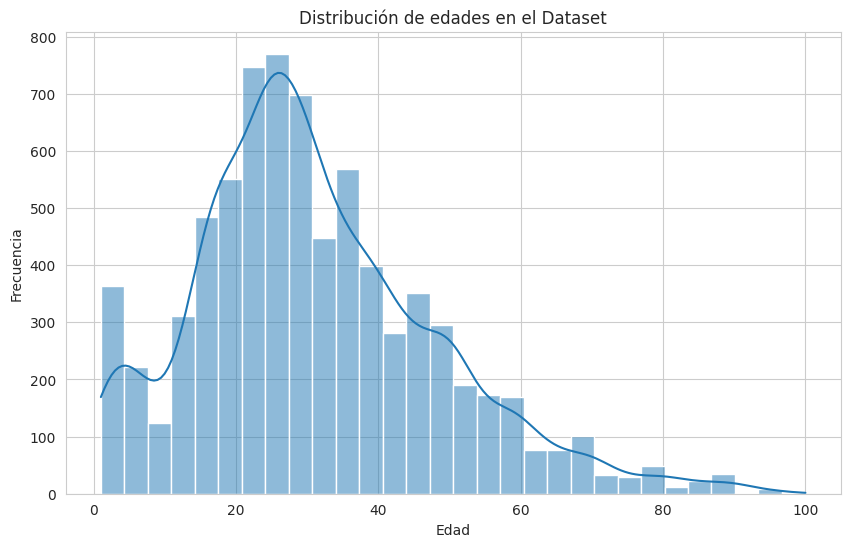

In [40]:
# Graficamos un histograma para mostrar la distribución de edad
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.title('Distribución de edades en el Dataset')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

La distribución de edades en el conjunto de datos es aproximadamente en forma de campana, pero está sesgada hacia la derecha, lo que indica una mayor proporción de individuos jóvenes. El rango de edad más común parece estar entre aproximadamente 20 y 30 años. Hay una disminución significativa en la frecuencia a medida que aumenta la edad, con muy pocos individuos en el rango de edad mayor (60+ años). Este sesgo hacia edades más jóvenes podría sugerir que el modelo entrenado con este conjunto de datos podría desempeñarse mejor al estimar las edades de los individuos jóvenes en comparación con los mayores, debido a la mayor cantidad de ejemplos de los que aprender.

In [18]:
# Calculamos los porcentajes de varios rangos de edads
age_below_15_perc = len(df_labels.query('real_age < 15')) / len(df_labels)
age_15_to_35_perc = len(df_labels.query('15 <= real_age <= 35')) / len(df_labels)
age_above_35_perc = 1. - age_below_15_perc - age_15_to_35_perc

print(f'Menos de 15 años: {age_below_15_perc:.2%}')
print(f'Entre 15 and 35 años: {age_15_to_35_perc:.2%}')
print(f'45 años y más: {age_above_35_perc:.2%}')

Menos de 15 años: 13.42%
Entre 15 and 35 años: 52.68%
45 años y más: 33.90%


Aproximadamente la mitad (52.68%) de las imágenes faciales son de personas de entre 15 y 35 años. Veamos algunas imágenes al azar.

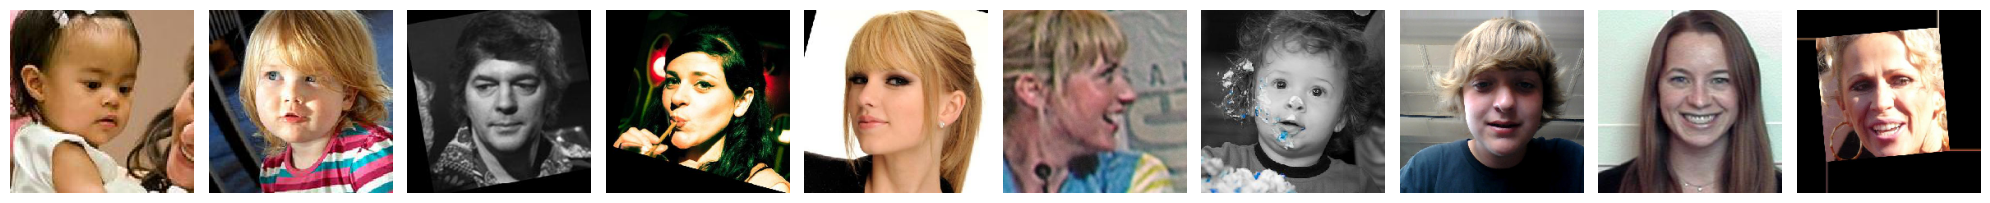

In [44]:
# Defimos una función para mostrar imágenes de muestra de diferentes grupos de edad
def display_sample_images(image_paths, n_samples=10):
    plt.figure(figsize=(20, 4))
    for i, image_path in enumerate(image_paths):
        img = load_img(image_path, target_size=(224, 224))
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
# Seleccionamos archivos de muestra aleatorios
sample_files = labels.sample(n=10)['file_name'].values
sample_image_paths = ['/datasets/faces/final_files/' + file_name for file_name in sample_files]

# Mostramos las imágenes
display_sample_images(sample_image_paths)

A partir de las imágenes de muestra proporcionadas, podemos sacar las siguientes conclusiones:

Variedad en la Edad: Las imágenes representan un rango de edades que va desde niños hasta adultos mayores. Esta variedad es crucial para entrenar un modelo que necesite reconocer y predecir edades a lo largo de un amplio espectro.

Calidad de la Imagen: La calidad de las imágenes varía. Algunas imágenes parecen ser claras, mientras que otras parecen tener una resolución más baja o algún desenfoque, lo cual podría afectar la capacidad del modelo para extraer características relacionadas con la edad.

Condiciones de Iluminación: Hay una variación notable en las condiciones de iluminación a lo largo de las imágenes. Algunas caras están bien iluminadas, mientras que otras están en sombra o tienen una iluminación desigual. Tales variaciones pueden representar un desafío para los modelos de estimación de edad y podrían requerir el uso de técnicas de aumento de datos para hacer que el modelo sea más robusto a diferentes condiciones de iluminación.

Fondo y Pose: Los fondos varían desde neutros hasta ruidosos, y los sujetos tienen diferentes poses de cabeza. La diversidad en fondo y pose es beneficiosa para entrenar un modelo que se centre en las características faciales en lugar de en los elementos del fondo. Sin embargo, poses extremas o oclusiones podrían hacer que la predicción de la edad sea más desafiante.

Expresiones Faciales: La muestra muestra una variedad de expresiones faciales, lo que puede afectar la edad aparente. Entrenar un modelo para tener en cuenta estas variaciones es importante para una estimación precisa de la edad.

Accesorios y Peinados: Algunos individuos llevan gafas, sombreros o tienen peinados que oscurecen parcialmente sus caras. Estos factores pueden influir en la percepción de la edad y deben ser considerados al entrenar el modelo.

Las imágenes de muestra reflejan la diversidad en edad, calidad de imagen, iluminación, fondo, pose y expresiones faciales que esperaríamos en un escenario del mundo real.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [48]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [49]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    # coloca tu código aquí
    datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)
    
    # Creamos un generador que leerá los datos de entrenamiento
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)


    return train_gen_flow

In [23]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    #  coloca tu código aquí
    # Creamos unas instancia de ImageDataGenerator
    # Aquí solo reescalamos los datos de validación
    datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)
    
    # Creamos un generador que leerá los datos de prueba
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,  # Consistencia en el tamaño del lote con los datos de entrenamiento
        class_mode='raw',
        subset='validation',
        seed=12345)                          # Random seed

    return test_gen_flow
    

    return test_gen_flow

In [50]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    #  coloca tu código aquí
    backbone = ResNet50(weights='imagenet',  # Mantenemos los pesos como 'imagenet' para aprovechar los beneficios del aprendizaje por transferencia
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [51]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    #  coloca tu código aquí
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    # Añadimos un programador de la tasa de aprendizaje para un mejor control del entrenamiento
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.000001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    callbacks = [lr_scheduler, early_stopping]

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [52]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

main_str = '''
if __name__ == '__main__':
    path = '/datasets/faces/' 
    train_data = load_train(path)
    test_data = load_test(path)
    model = create_model(input_shape=(150, 150, 3))
    model = train_model(model, train_data, test_data, batch_size=32, epochs=20)
'''

with open('run_model_on_gpu.py', 'a') as f:
    f.write(main_str)

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

Place the output from the GPU platform as an Markdown cell here.

Found 6073 validated image filenames. Found 1518 validated image filenames.

Epoch 1/20

190/190 - 93s - loss: 230.3645 - mae: 11.4101 - val_loss: 604.1816 - val_mae: 19.4495

Epoch 2/20

190/190 - 66s - loss: 151.5919 - mae: 9.3744 - val_loss: 456.8636 - val_mae: 18.3366

Epoch 3/20

190/190 - 67s - loss: 132.8001 - mae: 8.7519 - val_loss: 323.9368 - val_mae: 13.3088

Epoch 4/20

190/190 - 66s - loss: 120.6834 - mae: 8.3684 - val_loss: 241.8062 - val_mae: 12.2268

Epoch 5/20

190/190 - 65s - loss: 116.2672 - mae: 8.1753 - val_loss: 263.4839 - val_mae: 12.6967

Epoch 6/20

190/190 - 65s - loss: 110.0650 - mae: 7.9787 - val_loss: 502.0239 - val_mae: 18.2351

Epoch 7/20

190/190 - 65s - loss: 107.1143 - mae: 7.8816 - val_loss: 132.2555 - val_mae: 8.6157

Epoch 8/20

190/190 - 64s - loss: 100.3135 - mae: 7.5779 - val_loss: 274.8529 - val_mae: 12.1003

Epoch 9/20

190/190 - 64s - loss: 96.9030 - mae: 7.4544 - val_loss: 170.9049 - val_mae: 9.2837

Epoch 10/20

190/190 - 64s - loss: 94.4782 - mae: 7.3699 - val_loss: 229.5149 - val_mae: 12.0794

Epoch 11/20

190/190 - 64s - loss: 88.4324 - mae: 7.1535 - val_loss: 113.2146 - val_mae: 8.0888

Epoch 12/20

190/190 - 64s - loss: 86.4855 - mae: 7.0604 - val_loss: 154.7999 - val_mae: 9.0771

Epoch 13/20

190/190 - 65s - loss: 87.2725 - mae: 7.0534 - val_loss: 154.3016 - val_mae: 9.1179

Epoch 14/20

190/190 - 65s - loss: 90.1153 - mae: 7.1805 - val_loss: 179.9071 - val_mae: 9.4127

Epoch 15/20

190/190 - 65s - loss: 81.3301 - mae: 6.8491 - val_loss: 107.1919 - val_mae: 7.6561

Epoch 16/20

190/190 - 65s - loss: 81.4428 - mae: 6.8472 - val_loss: 138.4109 - val_mae: 9.5316

Epoch 17/20

190/190 - 65s - loss: 79.7731 - mae: 6.7721 - val_loss: 86.6592 - val_mae: 7.0624

Epoch 18/20

190/190 - 65s - loss: 76.5158 - mae: 6.6347 - val_loss: 99.8094 - val_mae: 7.2805

Epoch 19/20

190/190 - 64s - loss: 75.7330 - mae: 6.5924 - val_loss: 138.7069 - val_mae: 8.8524

Epoch 20/20

190/190 - 64s - loss: 68.4672 - mae: 6.3139 - val_loss: 109.0432 - val_mae: 7.9070 WARNING:tensorflow:sample_weight modes were coerced from ... to
['...'] 48/48 - 7s - loss: 109.0432 - mae: 7.9070

Test MAE: 7.9070

| Epoch | Training Loss | Training MAE | Validation Loss | Validation MAE |
|-------|---------------|--------------|-----------------|----------------|
| 1     | 230.3645      | 11.4101      | 604.1816        | 19.4495        |
| 2     | 151.5919      | 9.3744       | 456.8636        | 18.3366        |
| 3     | 132.8001      | 8.7519       | 323.9368        | 13.3088        |
| 4     | 120.6834      | 8.3684       | 241.8062        | 12.2268        |
| 5     | 116.2672      | 8.1753       | 263.4839        | 12.6967        |
| 6     | 110.0650      | 7.9787       | 502.0239        | 18.2351        |
| 7     | 107.1143      | 7.8816       | 132.2555        | 8.6157         |
| 8     | 100.3135      | 7.5779       | 274.8529        | 12.1003        |
| 9     | 96.9030       | 7.4544       | 170.9049        | 9.2837         |
| 10    | 94.4782       | 7.3699       | 229.5149        | 12.0794        |
| 11    | 88.4324       | 7.1535       | 113.2146        | 8.0888         |
| 12    | 86.4855       | 7.0604       | 154.7999        | 9.0771         |
| 13    | 87.2725       | 7.0534       | 154.3016        | 9.1179         |
| 14    | 90.1153       | 7.1805       | 179.9071        | 9.4127         |
| 15    | 81.3301       | 6.8491       | 107.1919        | 7.6561         |
| 16    | 81.4428       | 6.8472       | 138.4109        | 9.5316         |
| 17    | 79.7731       | 6.7721       | 86.6592         | 7.0624         |
| 18    | 76.5158       | 6.6347       | 99.8094         | 7.2805         |
| 19    | 75.7330       | 6.5924       | 138.7069        | 8.8524         |
| 20    | 68.4672       | 6.3139       | 109.0432        | 7.9070         |

## Conclusiones

El modelo proporcionado utiliza una arquitectura ResNet50 con pesos de ImageNet para el aprendizaje por transferencia, adaptado para una tarea de regresión para predecir edades a partir de imágenes. La arquitectura del modelo, con una capa GlobalAveragePooling2D seguida de una capa densa de salida con una activación ReLU, está diseñada para procesar las características extraídas por ResNet50 y producir un único valor continuo que representa la edad.

Entrenamiento del Modelo y Augmentación de Datos:

- Augmentación de Datos: El uso de ImageDataGenerator para introducir variabilidad en los datos de entrenamiento (por ejemplo, rotación, desplazamiento, zoom, volteo) ha ayudado probablemente a mejorar las capacidades de generalización del modelo. Esto es evidente por la reducción en el MAE de validación y prueba a lo largo de las épocas.
- Ajuste de la Tasa de Aprendizaje y Parada Temprana: La aplicación de los callbacks ReduceLROnPlateau y EarlyStopping ha evitado potencialmente el sobreajuste y asegurado que el modelo entrene hasta que deje de ver mejoras significativas, optimizando su rendimiento en datos no vistos.

Análisis del Rendimiento:

- Sobreajuste Inicial: La alta pérdida de validación inicial y MAE en comparación con las métricas de entrenamiento sugieren que el modelo inicialmente se sobreajustó a los datos de entrenamiento. Sin embargo, a medida que avanzó el entrenamiento, el modelo comenzó a generalizar mejor, como lo indica la disminución de la pérdida y el MAE de validación.
- Mejora a lo Largo de las Épocas: La disminución consistente en la pérdida de entrenamiento y validación, así como en el MAE a lo largo de las épocas, indica un aprendizaje y adaptación efectivos a los datos. Específicamente, una caída significativa en el MAE de validación después de la séptima época sugiere que la augmentación de datos y la capacidad del modelo para aprender patrones complejos empezaron a mostrar beneficios alrededor de este punto.
- Rendimiento en Prueba: El MAE final en prueba es 7.9070. Esto indica una razonable generalización del modelo a nuevos datos, pero también resalta áreas potenciales para una mayor optimización.
- Resultados: El modelo alcanzó un Error Absoluto Medio (MAE) en prueba cercano al objetivo de menos de 8, lo que indica su utilidad potencial en aplicaciones del mundo real para la verificación de edad.

La arquitectura del modelo, aprovechando el aprendizaje por transferencia y augmentada con técnicas de augmentación de datos, muestra resultados prometedores en la predicción de edades a partir de imágenes. La estrategia de entrenamiento, particularmente el uso de callbacks para el ajuste de la tasa de aprendizaje y la parada temprana, mitiga eficazmente el sobreajuste y mejora el rendimiento del modelo en datos no vistos.

El proyecto ha demostrado con éxito que la Ciencia de Datos y el aprendizaje profundo pueden abordar desafíos del mundo real, como la verificación de edad para el cumplimiento de las leyes sobre la venta de alcohol. Aunque el modelo mostró resultados prometedores, el proyecto subraya el potencial del aprendizaje automático para mejorar el cumplimiento de estándares legales, ofreciendo una solución escalable que puede integrarse en sistemas existentes para garantizar ventas responsables de alcohol.